In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from torch.optim.optimizer import Optimizer
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import random
import torch
import warnings 
warnings.filterwarnings('ignore')
from pytorch_lightning import seed_everything
import os
import gc
from transformers import pipeline
import requests
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering
from transformers import Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
gc.collect()

0

# functions

In [2]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
random_state = set_seed(42)

#MADGRAD 
exec(requests.get('https://raw.githubusercontent.com/facebookresearch/madgrad/main/madgrad/madgrad.py').text)

Global seed set to 42


# load data and split data (train,val)

In [3]:

from sklearn.model_selection import train_test_split
df = pd.read_csv('../data/preprocess_for_SQUAD_產品.csv',index_col=0)[['string_X_train','Y_label','string_Y_1','string_Y_2']].dropna(axis=0)
print(df.shape)
train_df, val_df = train_test_split(df,test_size=0.2,random_state=random_state)
display(train_df.head(3)),display(val_df.head(3))

(11200, 4)


,string_X_train,Y_label,string_Y_1,string_Y_2
70,12MTS OF OUTSOLE MATERIAL FOR MAKING SHOES EVA...,TAISOX 7470M,48,60
7626,1 QUANTITY 301000 KGS VISCOSE STAPLE FIBER ...,GRADE,96,101
5230,COPPER FOIL 05 OZ 50IN 10 OZ 45IN 10 OZ 50IN...,COPPER FOIL,1,12


,string_X_train,Y_label,string_Y_1,string_Y_2
4499,1 FCL 152000 METRIC TONNES 5 PCT METHYL METHA...,METHYL METHACRYLATE,34,53
3653,POLYPROPYLENE RESIN GRADE NOK1023 25 MTSAS P...,GRADE,21,26
4883,CIF HONG KONGDESCRIPTION RAW MATERIAL ACRYLON...,AG12A0,96,102


(None, None)

# load model and tokenizer

In [4]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

# Data preprocessing

In [5]:
def preprocessing(df):
    contexts = df['string_X_train'].values.tolist()
    questions = [ 'What is the product name ?' for i in range(len(df))]
    answers = []
    for idx in df.index:
        answers.append({
            'text':df.loc[idx,'Y_label'],
            'answer_start':df.loc[idx,'string_Y_1'],
            'answer_end':df.loc[idx,'string_Y_2'],
            })
    return contexts ,questions ,answers

In [6]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})
    return encodings

In [7]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [8]:
def df2Dataloader(df):
    contexts ,questions ,answers = preprocessing(df)
    encodings = tokenizer(contexts, questions, truncation=True, padding=True)
    encodings = add_token_positions(encodings, answers)
    dataset = SquadDataset(encodings)
    return DataLoader(dataset,batch_size=8)

In [9]:
train_loader = df2Dataloader(train_df)
val_loader = df2Dataloader(val_df)

# train model

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.train()
optimizer = MADGRAD(model.parameters() ,lr = 5e-5)

In [11]:
def step(model,batch,optimizer,device,mode='train'):
    model = model.to(device)
    # change mode
    if mode == 'train':
        model.train()
    if mode == 'val':
        model.eval()
    # forward pass
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    # update model if mode == train
    if mode == 'train': 
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss.item()

In [12]:
def train_loop(model,train_loader,val_loader,optimizer,max_epochs=5):
    history = {'train_loss':[],'val_loss':[]}
    best_loss = np.inf
    best_model = None
    for epoch in tqdm(range(max_epochs)):        
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        for i,batch in enumerate(tqdm(train_loader)):
            epoch_train_loss += step(model,batch,optimizer,device,mode='train')
        for j,batch in enumerate(tqdm(val_loader)):
            epoch_val_loss += step(model,batch,optimizer,device,mode='val')
        history['train_loss'].append(epoch_train_loss/i)
        history['val_loss'].append(epoch_val_loss/j)
        print(f'epoch:{epoch} train_loss:{epoch_train_loss/i} val_loss:{epoch_val_loss/j}')
        if history['val_loss'][-1] <= best_loss: 
            best_model = deepcopy(model.eval())
            best_loss = history['val_loss'][-1]
            print(f'save best_model now_val_best_loss is:{best_loss}')
    return best_model.eval() ,history

In [13]:
best_model ,history = train_loop(model,train_loader,val_loader,optimizer,max_epochs=3)


epoch:0 train_loss:0.3198707189608208 val_loss:0.05894651678999999
save best_model now_val_best_loss is:0.05894651678999999



epoch:1 train_loss:0.1291514887763682 val_loss:0.12668562047143353



epoch:2 train_loss:0.08935910925436741 val_loss:0.054676813897638794
save best_model now_val_best_loss is:0.054676813897638794



# save model

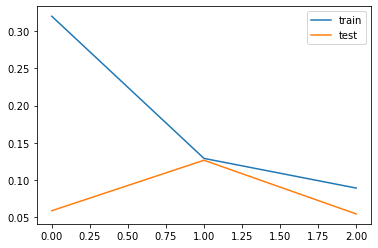

In [14]:
import matplotlib.pyplot as plt
plt.plot(history['train_loss'],label='train')
plt.plot(history['val_loss'],label='test')
plt.legend()
plt.show()

In [15]:
model_path = '../models/Product_Data_SQuAD_model_product.pt'
torch.save(best_model.state_dict(),model_path)

# load trained model

In [16]:
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
model.load_state_dict(torch.load(model_path))
model.eval()
nlp = pipeline('question-answering', model=model.to('cpu'), tokenizer=tokenizer)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

# test

In [17]:
def test_model(nlp,df):
    table = pd.DataFrame()
    for i in tqdm(df.index):
        sample = df.loc[[i]]
        string_X_train = sample['string_X_train'].values[0]
        Y_label = sample['Y_label'].values[0]  
        QA_input = {
            'question': 'What is the product name?',
            'context': string_X_train
        }
        res = nlp(QA_input)
        predict = QA_input['context'][res['start']:res['end']]
        row = pd.DataFrame({'Y_label':Y_label,'predict':predict},index=[i])
        if Y_label == predict:
            row['是否全對'] = 'Yes'
        else:
            row['是否全對'] = 'No'
        table = table.append(row)
    return table

In [18]:
table = test_model(nlp,val_df)
display(table)

,Y_label,predict,是否全對
4499,METHYL METHACRYLATE,METHYL METHACRYLATE,Yes
3653,GRADE,GRADE,Yes
4883,AG12A0,AG12A0,Yes
7498,AG12A0,AG12A0,Yes
17941,GRADE,GRADE,Yes
...,...,...,...
3342,GRADE,GRADE,Yes
16593,METHYL METHACRYLATE,METHYL METHACRYLATE,Yes
20414,ACID,ACID,Yes
593,TAISOX 7470M,TAISOX 7470M,Yes


In [19]:
display(table[table['是否全對']=='Yes'])

,Y_label,predict,是否全對
4499,METHYL METHACRYLATE,METHYL METHACRYLATE,Yes
3653,GRADE,GRADE,Yes
4883,AG12A0,AG12A0,Yes
7498,AG12A0,AG12A0,Yes
17941,GRADE,GRADE,Yes
...,...,...,...
3342,GRADE,GRADE,Yes
16593,METHYL METHACRYLATE,METHYL METHACRYLATE,Yes
20414,ACID,ACID,Yes
593,TAISOX 7470M,TAISOX 7470M,Yes


In [20]:
display(table[table['是否全對']=='No'])

,Y_label,predict,是否全對
5994,AG12A0,AG12A0 NATURALITEM,No
3749,PVC RESIN B 57,PVC RESIN,No
4333,48K,GRADE,No
1596,AG12A0,AG12A0 NATURALITEM,No
18243,POLYPROPYLENE RESIN,YUNGSOX 1005,No
...,...,...,...
7559,GRADE,AG10NPAK,No
15986,BOPP FILM PL50,PL50,No
222,PVC RESIN S60,PVC RESIN,No
4344,48K,GRADE,No


# claculate acc and jaccard

In [21]:
def get_acc(df,t=1):
    correct = []
    correct_label = []
    for i in df.index:
        jac = get_jaccard_sim(df.loc[i,'Y_label'],df.loc[i,'predict'])
        if jac >= t:
            correct.append('yes')
        else:
            correct.append('no')
    a = pd.Series(correct)
    return a.value_counts()['yes']/len(a)

In [22]:
print('jaccard_avg_score:',np.mean([ get_jaccard_sim(table['Y_label'].loc[i],table['predict'].loc[i]) for i in table.index]))
print('acc:',get_acc(table,1))
print('放水acc:',get_acc(table,0.75))
print('放水acc:',get_acc(table,0.5))
print('放水acc:',get_acc(table,0.25))

jaccard_avg_score: 0.9728222595856526
acc: 0.9602678571428571
放水acc: 0.9602678571428571
放水acc: 0.9763392857142857
放水acc: 0.9861607142857143


# 實驗

In [24]:
import requests
url = 'https://gist.githubusercontent.com/skywalker0803r/1e1d0d25999094bf8ec23dc143e02478/raw/2b751c959a1b48a14e627eaf956f9ae3df821f46/bert_train_pipeline.py'
exec(requests.get(url).text)

Global seed set to 42


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode


epoch:0 train_loss:0.3198707189608208 val_loss:0.05894651678999999
save best_model now_val_best_loss is:0.05894651678999999



epoch:1 train_loss:0.1291514887763682 val_loss:0.12668562047143353



epoch:2 train_loss:0.08935910925436741 val_loss:0.054676813897638794
save best_model now_val_best_loss is:0.054676813897638794



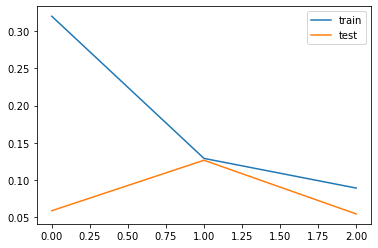

best_model is saved!


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

(    jaccard  acc(1.0)  acc(0.75)  acc(0.5)  acc(0.25)
 0  0.972822  0.960268   0.960268  0.976339   0.986161,
                    Y_label              predict 是否全對
 4499   METHYL METHACRYLATE  METHYL METHACRYLATE  Yes
 3653                 GRADE                GRADE  Yes
 4883                AG12A0               AG12A0  Yes
 7498                AG12A0               AG12A0  Yes
 17941                GRADE                GRADE  Yes
 ...                    ...                  ...  ...
 3342                 GRADE                GRADE  Yes
 16593  METHYL METHACRYLATE  METHYL METHACRYLATE  Yes
 20414                 ACID                 ACID  Yes
 593           TAISOX 7470M         TAISOX 7470M  Yes
 8399           EPOXY RESIN          EPOXY RESIN  Yes
 
 [2240 rows x 3 columns])

In [25]:
qustion = 'What is the product name?'
model_path ='temp.pt' 
bert_train_pipeline(train_df,val_df,qustion,model_path)